# Simple deep multi-layer perceptron Sentinel 2 for the classification of the urban and agriculture areas

This notebook walks you through a simple example of using Earth Engine and Keras.

Specifically, we will train a neural network to recognize land, water, urbar, and cropland pixels in a Sentinel 2 scene 
For this simple example we will use the output of the USDA NASS Cropland Data Layers as training data.



# Websites that have been useful 

Skydippers CNN code - which the rest of this has been built off - https://github.com/Skydipper/cnn-models

GEE - Sentinel 2 website - ([Sentinel 2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2)). 

Crop Data Later - ([Crop_Data_Layer](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL))

Useful for creating visualisations of the model and confusion matrix - https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras/notebook

ann-vis - very pretty visualisations of CNN - if you can get it working - https://github.com/Prodicode/ann-visualizer cant get ann_visualizer to install

Introduction to CNN in Keras - https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

Visualising CNN in Keras - includes confusion matrix - https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

Learning Rate Schedules and Adaptive Learning Rate Methods - https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

Visialise CNN - including showing the visualisation layers - https://www.codeastar.com/visualize-convolutional-neural-network/

Includes how to generate a flow chart of the model - https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/

Difference between a batch and and Epoch - https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

Simple intro to CNN - https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac

Advanced into to CNN... - https://towardsdatascience.com/advanced-topics-in-deep-convolutional-neural-networks-71ef1190522d

Interesting histograms and adding legends to charts - https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/classify-plot-raster-data-in-python/


## Configure the Environment

In [1]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image
from functools import reduce
import h5py
import seaborn as sns
from ee_datasets import ee_datasets
import seaborn as sns
import sklearn


#from keras.models import Sequential
#from keras.layers import Dense, Dropout
#from keras.optimizers import RMSprop
#from keras.callbacks import Callback, ModelCheckpoint

Using TensorFlow backend.


Initialize Earth Engine client

In [2]:
ee.Initialize()

**Functions**

In [3]:
def display_image(image, region, Vizz = None):
    """
    Displays images in notebook
    """ 
    ## Visualization
    if Vizz:
        image = image.visualize(**Vizz)
        
    visual = Image(url=image.getThumbUrl({
                'region':region
                }))
    
    display(visual)

In [4]:
def CloudMaskS2(image):
    """
    European Space Agency (ESA) clouds from 'QA60', i.e. Quality Assessment band at 60m
    parsed by Nick Clinton
    """
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)

    # Both flags set to zero indicates clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
            qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

In [5]:
def CloudFreeCompositeS2(Collection_id, startDate, stopDate, geom):
    ## Define your collection
    collection = ee.ImageCollection(Collection_id)

    ## Filter 
    collection = collection.filterBounds(geom).filterDate(startDate,stopDate)\
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
            .map(CloudMaskS2)

    ## Composite
    composite = collection.median()
    
    return composite

## Sentinel 2  
### Sentinel-2 MSI: MultiSpectral Instrument, Level-1C ([gee](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2))
**Dataset Availability**: 2015-06-23T00:00:00 - Present

**Wavebands**

|Band 	|Use 		|Wavelength (nm) |Resolution (m)|
|-------|-----------|----------------|--------------|
|B1 	|Aerosols 	|443 	|60|
|B2 	|Blue 		|490 	|10|
|B3 	|Green 		|560 	|10|
|B4 	|Red 		|665 	|10|
|B6 	|Red Edge 2 |740 	|20|
|B8 	|NIR        |835 	|10|
|B8a 	|Red Edge 4 |865 	|20|
|B9 	|Water vapor|940 	|60|
|B10 	|Cirrus 	|1375 	|60|
|B11 	|SWIR 1 	|1610 	|20|
|B12 	|SWIR 2 	|2190 	|20|
|QA60   |ESA Cloud  | n/a   |60|

In [6]:
# GEE Image Collection ID
Collection_id = 'COPERNICUS/S2'
# Start and stop of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')
# Scale in meters
scale = 10

## Set the Area of Interest 

In [7]:
# Area of Interest (AoI)
geom = ee.Geometry.Polygon([[[-104.04, 42.988], [-96.49, 42.98],[-96.49, 45.94],[-104.04, 45.94],[-104.04, 42.98]]], None, False)
region = geom.bounds().getInfo()['coordinates']

**Cloud Free Composites of the test sites**

RGB

In [8]:
# Visualization parameters
vis = {'min':0,'max':0.3, 'bands':['B4','B3','B2']}
# Cloud Free Composite
image = CloudFreeCompositeS2(Collection_id, startDate, stopDate, geom)
# Display Composite
display_image(image, region, Vizz = vis)

NIR

In [9]:
# Visualization parameters
vis = {'min':0,'max':0.5, 'gamma':1.5, 'bands':['B8']}
# Display Composite
display_image(image, region, Vizz = vis)

NDVI = (RED-NIR)/(RED+NIR)

In [10]:
# Visualization parameters
palette = ['blue', 'white', 'green']
vis = {'min': -0.8, 'max': 0.8, 'bands':'nd', 'palette': palette}
# Calculate NDVI
image_ndvi = image.normalizedDifference(['B8','B4'])
# Display NDVI
display_image(image_ndvi, region, Vizz = vis)

NDWI = (GREEN-NIR)/(GREEN+NIR)

In [11]:
# Visualization parameters
palette = ['blue', 'white', 'green']
vis = {'min': -0.8, 'max': 0.8, 'bands':'nd', 'palette': palette}
# Calculate NDWI
image_ndwi = image.normalizedDifference(['B8','B3'])
# Display NDWI
display_image(image_ndwi, region, Vizz = vis)

## Cropland Data Layer
### USDA NASS Cropland Data Layers ([gee](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL))

**Dataset Availability**: January 1997 - Present

**Resolution**
30 meters

**Bands**

|Name 	    |Min|Max |Description 	|
|-----------|---|----|--------------|
|cropland 	|1 	|254 |Main crop-specific land cover classification.|
|cultivated |1 	|2   |Classification layer for identifying cultivated and non-cultivated land cover. Available from 2013 to 2017.|
|confidence |0 	|100 |Per-pixel predicted confidence of the given classification, with 0 being the least confident and 100 the most confident.|

In [12]:
# GEE Image Collection ID
Collection_id = 'USDA/NASS/CDL'

In [13]:
Collection_id

'USDA/NASS/CDL'

Ground truth land cover classification

In [14]:
dataset = ee.ImageCollection(Collection_id)\
    .filterBounds(geom)\
    .filterDate(startDate,stopDate)

# First image
image = ee.Image(dataset.first())

# Choose the scale
image =  image.reproject(crs='EPSG:4326', scale=scale)

In [15]:
vis = {'min':1,'max':254, 'bands':'cropland'}
display_image(image, region, Vizz = vis)

## Download datasets
We download and stack datasets from two different Areas of Interest (AOIs)

In [16]:
# Central position of (AOIs) - East and West of the Missouri river
points = [[-102.5463, 44.6842], [-97.580566, 43.678301]]

In [17]:
#from ee_datasets import ee_datasets

for n, point in enumerate(points):
    sentinel = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
    cropland = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'CroplandDataLayers')
    dataset_x = sentinel.read_datasets()
    dataset_y = cropland.read_datasets()
    if n == 0:
        data_x = dataset_x
        data_y = dataset_y
    else:
        szy1, szx1 = data_x.shape[:2]
        szy2, szx2 = dataset_x.shape[:2]
        if szy1 != szy2 or szx1 != szx2:
            szy = min(szy1, szy2)
            szx = min(szx1, szx2)
            
            data_x = np.stack((data_x[:szy,:szx,:], dataset_x[:szy,:szx,:]), axis=0)
            data_y = np.stack((data_y[:szy,:szx,:], dataset_y[:szy,:szx,:]), axis=0)
        else:
            data_x = np.stack((data_x, dataset_x), axis=0)
            data_y = np.stack((data_y, dataset_y), axis=0)

**Display channels**

We display the input and output datasets

In [18]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

In [19]:
def display_channels_long(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(40,40))
        fig.subplots_adjust(hspace=0.5, wspace=0.5)
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

Sentinel 2 composite for the for the fist AOI

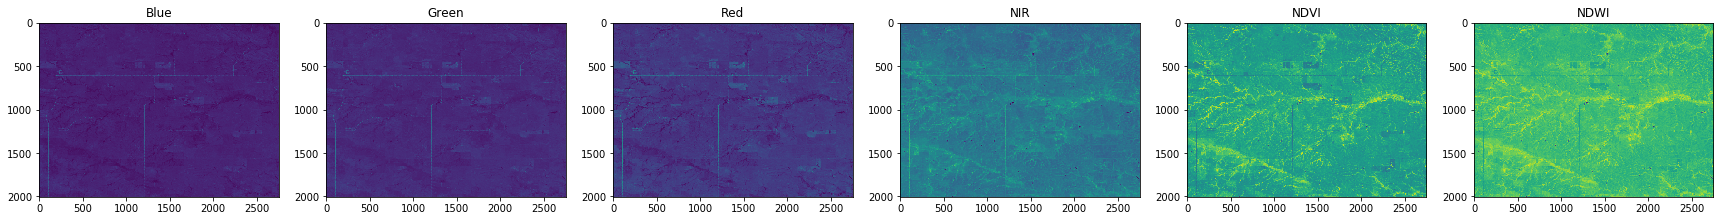

In [20]:
display_channels(data_x[0,:,:,:], data_x.shape[3], titles=['Blue', 'Green', 'Red', 'NIR', 'NDVI', 'NDWI'])

Ground truth land cover classification for the for the fist AOI

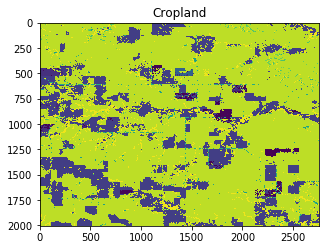

In [21]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles=['Cropland'])

Sentinel 2 composite for the for the second AOI

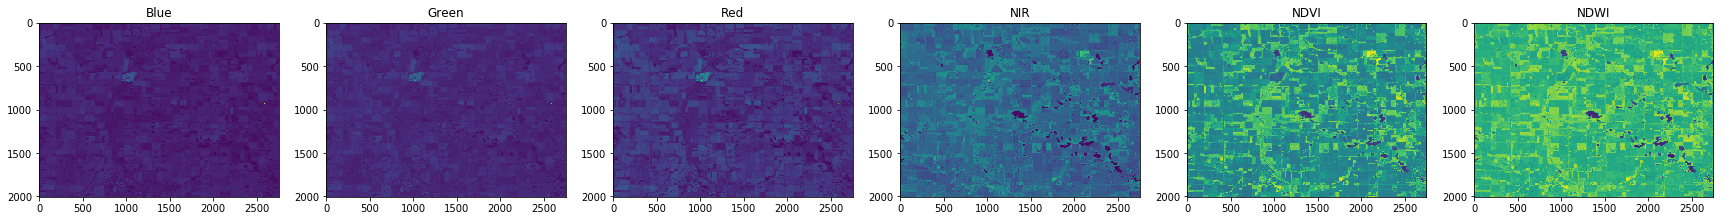

In [22]:
display_channels(data_x[1,:,:,:], data_x.shape[3], titles=['Blue', 'Green', 'Red', 'NIR', 'NDVI', 'NDWI'])

Ground truth land cover classification for the for the second AOI

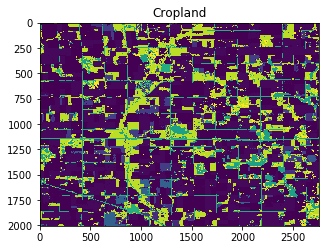

In [23]:
display_channels(data_y[1,:,:,:], data_y.shape[3], titles=['Cropland'])

## Preprocess class labels

Each class in encoded as a value in the range between 0 to 254. For training a Neural Network in Keras we have to convert the 1-dimensional class arrays to N classes-dimensional matrices. To simplify the problem here we regroup all the classes into 8 categories.

In [24]:
# Area of Interest (AoI)
geom = ee.Geometry.Point(points[0]).buffer(10000)
# Start and stop of time series
startDate = ee.Date('2016')
stopDate  = ee.Date('2017')
# Read the ImageCollection
dataset = ee.ImageCollection('USDA/NASS/CDL')\
    .filterBounds(geom)\
    .filterDate(startDate,stopDate)
# Get the cropland class values and names
cropland_info = pd.DataFrame({'cropland_class_values':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_values'),
                              'cropland_class_palette':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_palette'),
                              'cropland_class_names':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_names')
                             })
cropland_info.head()

,cropland_class_names,cropland_class_palette,cropland_class_values
0,Background,000000,0.0
1,Corn,ffd300,1.0
2,Cotton,ff2626,2.0
3,Rice,00a8e5,3.0
4,Sorghum,ff9e0c,4.0


The number of unique classes in this are is equal to:

In [25]:
len(np.unique(data_y[:,:,:,0]))

33

and the number of pixels by class

In [26]:
value, count = np.unique(data_y[0,:,:,0], return_counts=True)
df = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df = pd.merge(df, cropland_info, how='left', on=['cropland_class_values'])
df.head()

,cropland_class_counts,cropland_class_values,cropland_class_names,cropland_class_palette
0,4026130,176.0,Grassland/Pasture,e8ffbf
1,954430,37.0,Other Hay/Non Alfalfa,a5f28c
2,229119,190.0,Woody Wetlands,7fb2b2
3,78247,36.0,Alfalfa,ffa5e2
4,46567,121.0,Developed/Open Space,9b9b9b


In [27]:
value, count = np.unique(data_y[1,:,:,0], return_counts=True)
df = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df = pd.merge(df, cropland_info, how='left', on=['cropland_class_values'])
df.head()

,cropland_class_counts,cropland_class_values,cropland_class_names,cropland_class_palette
0,2013667,1.0,Corn,ffd300
1,1612165,5.0,Soybeans,267000
2,873435,176.0,Grassland/Pasture,e8ffbf
3,246536,121.0,Developed/Open Space,9b9b9b
4,229362,111.0,Open Water,4c70a3


In [41]:
# # Visualizing the number of different lables in training data 
# counts = df["cropland_class_counts"]
# #plt.figure(figsize=(8,4))
# sns.countplot(counts)
# # x='label', data=

In [30]:
# formula to change the class labels
def replace_values(array, class_labels, new_label):
    array_new = np.copy(array)
    for i in range(len(class_labels)):
        array_new[array == class_labels[i]] = new_label
        
    return array_new

## Reprocess the CDL categories into 8 classes

In [31]:
# set the number of classes and the number of epochs
epc = 25
cls = 8
#chart titles
titles = ['Corn', 'Soy', 'Wheat', 'Alfalfa','Other Hay','Water','Grass','Other']

In [36]:
# New classes
corn = ['1']
soy = ['5']
wheat = ['22', '23', '24']
alf = ['36']
nonalf = ['37']
water = ['111']
grass = ['176']

#Concatenated list of classes
combined_classes = corn+soy+wheat+alf+nonalf+water+grass

class_labels_1 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(corn)])
class_labels_2 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(soy)])
class_labels_3 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(wheat)])
class_labels_4 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(alf)])
class_labels_5 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(nonalf)])
class_labels_6 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(water)]) 
class_labels_7 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(grass)]) 
class_labels_8 = np.array(cropland_info['cropland_class_values'][~cropland_info['cropland_class_values'].isin(combined_classes)])

# We replace the class labels - use 1000s to make sure values are not overwritten
new_data_y = np.copy(data_y[:,:,:,0])
new_data_y = replace_values(new_data_y, class_labels_1, 1000.)
new_data_y = replace_values(new_data_y, class_labels_2, 2000.)
new_data_y = replace_values(new_data_y, class_labels_3, 3000.)
new_data_y = replace_values(new_data_y, class_labels_4, 4000.)
new_data_y = replace_values(new_data_y, class_labels_5, 5000.)
new_data_y = replace_values(new_data_y, class_labels_6, 6000.)
new_data_y = replace_values(new_data_y, class_labels_7, 7000.)  
new_data_y = replace_values(new_data_y, class_labels_8, 8000.)

#Divide by 1000 and subtract 1 to get results 0 to 7
new_data_y = np.divide(new_data_y, 1000.) -1


# Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. 
# We reshape all data to 28x28x1 3D matrices.
# Keras requires an extra dimension in the end which correspond to channels. 
# MNIST images are gray scaled so it use only one channel. 
# For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.
# above taken from - https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

# Convert 1-dimensional class arrays to 4-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, cls)


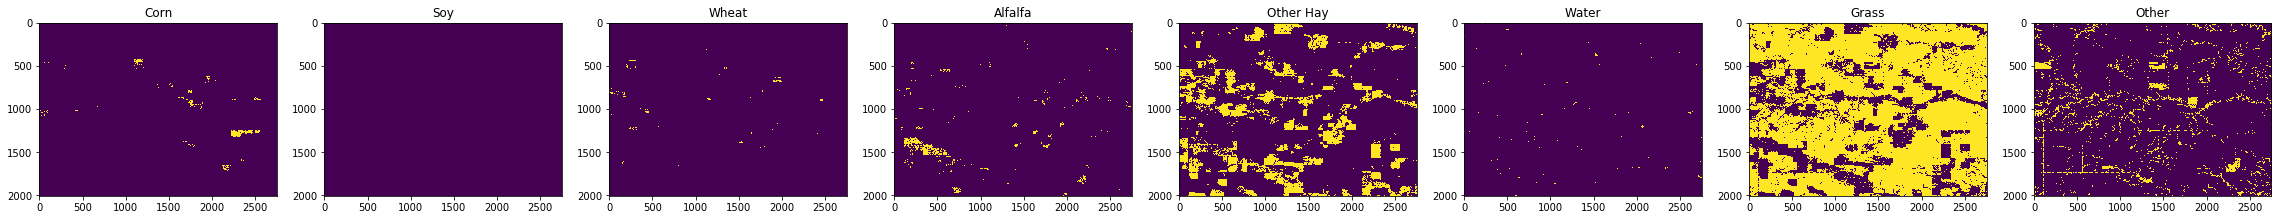

In [38]:
display_channels(new_data_y[0,:,:,:], new_data_y.shape[3], titles=titles)

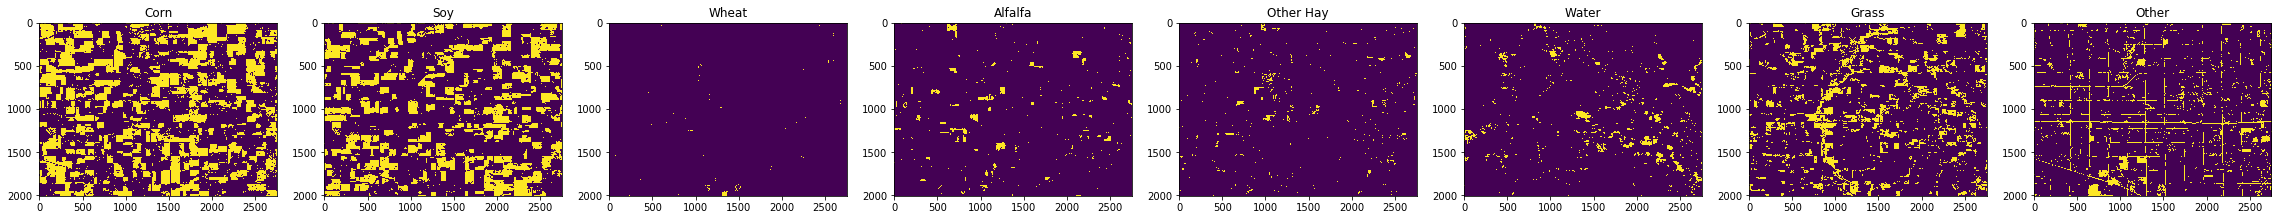

In [39]:
display_channels(new_data_y[1,:,:,:], new_data_y.shape[3], titles=titles)

In [40]:
#final piece of puts data_y to equal new data
data_y = new_data_y

New classification for the for the first AOI

In [ ]:
class_labels_5

In [ ]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles=titles)

### Checks on the shape and type of the datasets

In [ ]:
type(data_y)

In [ ]:
#data_y size
np.size(data_y)

In [ ]:
#shapre of data_y
np.shape(data_y)

In [ ]:
#number of dimensions in the data_y array
np.ndim(data_y)

### Interesting ways of presenting the data 
Need to transfer data_y into a pandas DF from numpy to get below 2 steps to work

In [ ]:
# won't work as data needs to be reformatted into pandas
# data_y_df = pd.DataFrame({'Column1':data_y})

In [ ]:
#also wont work as data in wrong format - put it in panda?
#sns.pairplot(data_y, hue='class')

In [ ]:
#doesn't work on 4d matrix
#sns.countplot(data_y)

New classification for the for the second AOI

In [ ]:
display_channels(data_y[1,:,:,:], data_y.shape[3], titles=titles)

In [ ]:
display_channels(new_data_y[1,:,:,:], new_data_y.shape[3], titles=titles)

**Select input channels**

We will only use NIR, NDVI, and NDWI as an input channels - maybe a good test to try on the visable spectrum as well 

In [ ]:
data_x = data_x[:,:,:,3:]

## Preprocess datasets for training a Fully Connected Network (FCN)

**Normalize data**

In [ ]:
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data[:,:,:,i].max()
        mn = data[:,:,:,i].min()
        
        data[:,:,:,i] = (data[:,:,:,i]-mn)/(mx-mn)
    return data

In [ ]:
data_x = normalize_data(data_x)

In [ ]:
plt.imshow(data_x[0])

**Resize the images**

In [ ]:
# Current shape
data_x.shape

In [ ]:
data_y.shape

In [ ]:
def reshape_data(data):
    size = data.shape
    new_size = []
    new_size.append(reduce(lambda x, y: x*y, size[:-1]))
    new_size.append(size[-1])
    new_size = tuple(new_size)
    return size, new_size

In [ ]:
size_x, new_size_x = reshape_data(data_x)
size_y, new_size_y = reshape_data(data_y)

data_x_new = data_x.reshape(new_size_x)
data_y_new = data_y.reshape(new_size_y)

Check on the new shape for x and y

In [ ]:
data_x_new.shape

In [ ]:
data_y_new.shape

**Randomize the datasets**

In [ ]:
def randomize_datasets(data_x, data_y):
    t=data_x.shape[0]
    arr_t = np.arange(t)
    np.random.shuffle(arr_t)
    data_x = data_x[arr_t,:]
    data_y = data_y[arr_t,:]
    
    return data_x, data_y

In [ ]:
x_randm, y_randm = randomize_datasets(data_x_new, data_y_new)

**Training and validation sets**

In [ ]:
def train_validation_split(x, y, val_size=20):
    t=x.shape[0]
    size = int(t*((100-val_size)/100))
    
    xt = x[:size,:]
    xv = x[size:,:]
    yt = y[:size,:]
    yv = y[size:,:]
    
    return xt, xv, yt, yv

In [ ]:
x_train, x_validation, y_train, y_validation = train_validation_split(x_randm, y_randm)

In [ ]:
# Visualizing the number of different lables in training data 
#plt.figure(figsize=(8,4))
#sns.countplot(x='label', data=x_validation);

## Define the Keras model

Here we define a neural network with two hidden layers with `relu` nonlinearities.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
#from keras.optimizers import RMSprop
#from keras.callbacks import Callback, ModelCheckpoint

# changed num_classes to howeveer many classes you set above
# set the number of epochs to 35 for full run, 1-3 for testing 
batch_size = 32
num_bands = 3
num_classes = cls
epochs = epc

model = Sequential()

model.add(Dense(512, activation = 'relu', input_shape=(num_bands,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

### Create a flow chart of the model - doesn't work yet

In [ ]:
#create a plot of the model 
#model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, axis=1)

**Compile the model**

In [ ]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

**Train the Neural Network**

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint

In [ ]:
# To saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath="{0}_weights.hdf5".format('FCN'), verbose=1, save_best_only=True)

In [ ]:
history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_validation, y_validation), callbacks=[checkpointer])

**Evaluate model**

In [ ]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Visualising the keras model 

In [ ]:
# taken from https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x_train[10])

#.reshape(1,28,28,1

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

### More visualisation parameters

Would be useful if you could get these working 

In [ ]:
# data visualisation
# https://towardsdatascience.com/visualizing-artificial-neural-networks-anns-with-just-one-line-of-code-b4233607209e
from ann_visualizer.visualize import ann_viz;
ann_viz(model, title="Neural Network Visualisation")

#display the second layer in an 8x8 grid (8,8,1)
display_activation(activations, 8, 8, 1)

# Model analysis Graphs

In [ ]:
model.freeze_to(-1)
model.lr_find()
model.recorder.plot()

In [ ]:
#Plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix

In [ ]:
# taken from https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras
from sklearn.metrics import confusion_matrix
Y_prediction = model.predict(x_validation)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validation,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

In [ ]:
#plot the matrix
plt.figure(figsize=(cls,cls))
confuse = sns.heatmap(confusion_mtx, annot=True, fmt="d");
confuse.set(xlabel='Predicted', ylabel='Actual')

**Read the weights**

In [ ]:
#changed the num_classes from 4 to 6
batch_size = 32
num_bands = 3
num_classes = cls
epochs = epc

model = Sequential()
model = Sequential()

model.add(Dense(512, activation = 'relu', input_shape=(num_bands,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

model.load_weights("{0}_weights.hdf5".format('FCN'))

## Predict on the test region

Test the FCN on the central region of South Dakota

In [ ]:
# Central position of (AOIs) - Piere in the centre of South Dakota with the Missouri river running through it
point = [-100.3862, 44.362642]

In [ ]:
# buffer set to 10k - usually set to 10k - much larger area used
sentinel = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
dataset_x = sentinel.read_datasets()
cropland = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'CroplandDataLayers')
dataset_y = cropland.read_datasets()

We select the NIR, NDVI, NDWI channels

In [ ]:
data_x = dataset_x[:,:,3:]
data_y = dataset_y

Sentinel 2 composite

In [ ]:
display_channels(data_x, data_x.shape[2], titles=['NIR', 'NDVI', 'NDWI'])

Ground truth land cover classification

In [ ]:
display_channels(data_y, data_y.shape[2], titles=['Cropland'])

**Preprocess class labels**

In [ ]:
# We replace the class labels - the data here has been amended to reflect 6 categories
new_data_y = np.copy(data_y[:,:,0])
new_data_y = replace_values(new_data_y, class_labels_7, 7.)
new_data_y = replace_values(new_data_y, class_labels_6, 6.)
new_data_y = replace_values(new_data_y, class_labels_5, 5.)
new_data_y = replace_values(new_data_y, class_labels_4, 4.)
new_data_y = replace_values(new_data_y, class_labels_3, 3.)
new_data_y = replace_values(new_data_y, class_labels_2, 2.)
new_data_y = replace_values(new_data_y, class_labels_1, 1.)
new_data_y = replace_values(new_data_y, class_labels_0, 0.)

# Convert 1-dimensional class arrays to 4-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, cls)

Output classes

In [ ]:
display_channels(new_data_y, new_data_y.shape[2], titles=titles)

**Preprocess input dataset**

In [ ]:
# Normalize
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data[:,:,i].max()
        mn = data[:,:,i].min()
        
        data[:,:,i] = (data[:,:,i]-mn)/(mx-mn)
    return data
data_x_norm = normalize_data(data_x)

In [ ]:
# Normalize
data_x_norm = normalize_data(data_x)
# Resize
size_x, new_size_x = reshape_data(data_x_norm)

x_input = data_x_norm.reshape(new_size_x)

**Compute the prediction**

In [ ]:
y_output = model.predict(x_input, batch_size=batch_size, verbose=0)

**Resize the output**

In [ ]:
data_y_output = y_output.reshape((size_x[0], size_x[1],cls))

**Display the output**

In [ ]:
display_channels(data_y_output, data_y_output.shape[2], titles=titles)

We binarize the output taking the highest pixel value

In [ ]:
# Binarize the output
def max_pixels(x):
    x_new = x*0
    max_val = np.amax(x, axis=2)
    size = x.shape
    for i in range(size[-1]):
        ima = x[:,:,i]*0
        ima[np.where(x[:,:,i] == max_val)] = 1
        x_new[:,:,i]= ima

    return x_new

In [ ]:
data_y_output_max = max_pixels(data_y_output)

In [ ]:
display_channels(data_y_output_max, data_y_output.shape[2], titles=titles)

If we compare the ground truth with the prediction we find that the FCN performes quite well for the land, water, and cropland areas but it fails in detecting urban areas.

# Run the above model on large part of South Dakota

In [ ]:
# Below is an attempt to get the model to run on a polygon instead of a point with a buffer - needs more work 
#point = ee.Geometry.Polygon([[[-104.04, 42.988], [-96.49, 42.98],[-96.49, 45.94],[-104.04, 45.94],[-104.04, 42.98]]], None, False)
#region = geom.bounds().getInfo()['coordinates']

#point = geom

In [ ]:
# Central position of South Dakota
point = [-99.607445, 43.234448]

Below is run on a point with a larger buffer - but would be better off running on a polygon

In [ ]:
# read fom ee_datasets but needs to be switched to read the data from amended file ee_datasets_polygon

# buffer set to 100k - usually set to 10k - much larger area used
sentinel = ee_datasets(point = point, buffer = 100000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
dataset_x = sentinel.read_datasets()
cropland = ee_datasets(point = point, buffer = 100000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'CroplandDataLayers')
dataset_y = cropland.read_datasets()

In [ ]:
data_x = dataset_x[:,:,3:]
data_y = dataset_y

In [ ]:
display_channels(data_x, data_x.shape[2], titles=['NIR', 'NDVI', 'NDWI'])

In [ ]:
display_channels(data_y, data_y.shape[2], titles=['Cropland'])

In [ ]:
# We replace the class labels - the data here has been amended to reflect 6 categories
new_data_y = np.copy(data_y[:,:,0])
new_data_y = replace_values(new_data_y, class_labels_7, 7.)
new_data_y = replace_values(new_data_y, class_labels_6, 6.)
new_data_y = replace_values(new_data_y, class_labels_5, 5.)
new_data_y = replace_values(new_data_y, class_labels_4, 4.)
new_data_y = replace_values(new_data_y, class_labels_3, 3.)
new_data_y = replace_values(new_data_y, class_labels_2, 2.)
new_data_y = replace_values(new_data_y, class_labels_1, 1.)
new_data_y = replace_values(new_data_y, class_labels_0, 0.)

# Convert 1-dimensional class arrays to 4-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, cls)

In [ ]:
display_channels(new_data_y, new_data_y.shape[2], titles=titles)

In [ ]:
# Normalize
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data[:,:,i].max()
        mn = data[:,:,i].min()
        
        data[:,:,i] = (data[:,:,i]-mn)/(mx-mn)
    return data
data_x_norm = normalize_data(data_x)

In [ ]:
# Normalize
data_x_norm = normalize_data(data_x)
# Resize
size_x, new_size_x = reshape_data(data_x_norm)

x_input = data_x_norm.reshape(new_size_x)

In [ ]:
y_output = model.predict(x_input, batch_size=batch_size, verbose=0)

In [ ]:
data_y_output = y_output.reshape((size_x[0], size_x[1],cls))

In [ ]:
display_channels(data_y_output, data_y_output.shape[2], titles=titles)

In [ ]:
# Binarize the output
def max_pixels(x):
    x_new = x*0
    max_val = np.amax(x, axis=2)
    size = x.shape
    for i in range(size[-1]):
        ima = x[:,:,i]*0
        ima[np.where(x[:,:,i] == max_val)] = 1
        x_new[:,:,i]= ima

    return x_new

In [ ]:
data_y_output_max = max_pixels(data_y_output)

In [ ]:
display_channels(data_y_output_max, data_y_output.shape[2], titles=titles)